Import required libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Load the cleaned training datasets

In [3]:
Training_protein_peptide=pd.read_csv('Protein_peptide_training.csv')
Training_clinical=pd.read_csv('Training_clinical_cleaned.csv')

In [4]:
Training_protein_peptide.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,732430.0


In our data_wrangling notebook, we saw that the PeptideAbundance and NPX values are non-log2 normalised. To ensure a normal-like distribution we log2 transform our values 

In [5]:
range_protein=(Training_protein_peptide.NPX.min(),Training_protein_peptide.NPX.max())
range_peptide=(Training_protein_peptide.PeptideAbundance.min(),Training_protein_peptide.PeptideAbundance.max())
print(range_protein)
print(range_peptide)

(84.6082, 613851000.0)
(10.9985, 178752000.0)


In [6]:
Training_protein_peptide["Normalised_PeptideAbundance"]=np.log2(Training_protein_peptide.loc[:,"PeptideAbundance"])


In [7]:
Training_protein_peptide["Normalised_NPX"]=np.log2(Training_protein_peptide.NPX)

In [8]:
range_normalised_protein=(Training_protein_peptide.Normalised_NPX.min(),Training_protein_peptide.Normalised_NPX.max())
range_normalised_peptide=(Training_protein_peptide.Normalised_PeptideAbundance.min(),Training_protein_peptide.Normalised_PeptideAbundance.max())
print(range_normalised_protein)
print(range_normalised_peptide)

(6.40272558714566, 29.193313271945524)
(3.4592348740806513, 27.413384142942036)


Plot the normalised protein and peptide abundances

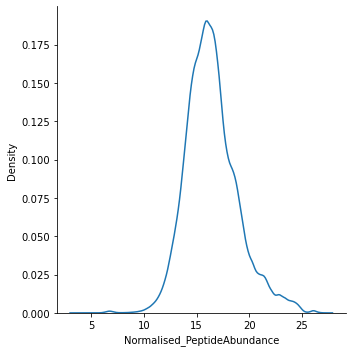

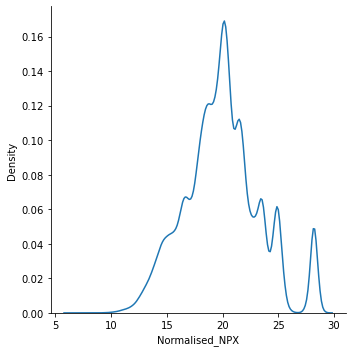

In [9]:
sns.displot(Training_protein_peptide,x="Normalised_PeptideAbundance",kind="kde");
sns.displot(Training_protein_peptide,x="Normalised_NPX",kind="kde");

For prediction analyses we are only interested in the visit_months 0, 6 , 12 and 24 months. Let us remove the rest of the visit_months in the range before proceeding with EDA

In [10]:
select_months=[0,6,12,24]
Training_protein_peptide_select=Training_protein_peptide[Training_protein_peptide["visit_month"].isin(select_months)]

Can we see the frequency of detection of different Uniprot IDs in a histogram


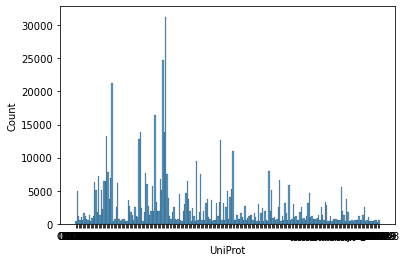

In [11]:
sns.histplot(x="UniProt",data=Training_protein_peptide_select);



It can be seen that the number of proteins for each type of protein varys considerably. This may be due to the differences in the number of peptides for each protein.
Let us plot the number of peptides for each protein 

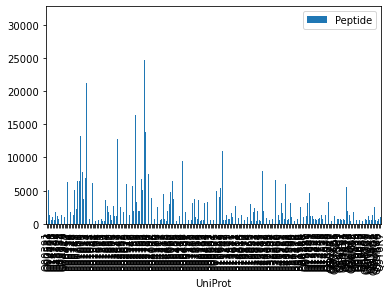

In [12]:

Training_protein_peptide_select[['UniProt', 'Peptide']].groupby(['UniProt']).count().plot(kind='bar',stacked=True);



Yes no of peptides vary alot with each protein

We would also like to see if the patient_nos vary between different months 

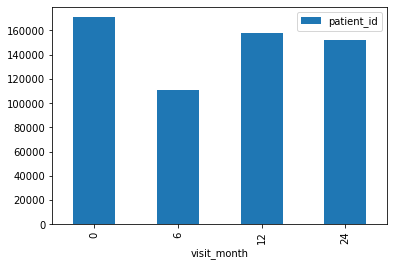

In [13]:
df1=Training_protein_peptide_select[['patient_id', 'visit_month']]
df1.groupby(['visit_month']).count().plot(kind='bar');


Given that they are different peptides associated with each Protein (UniProt ID), we would like to select only those which are likely the most important. For this we will only consider those peptides which ahve 

We would like to see how samples ids group separately based on protein NPX values and peptide abundances. We will make use of principal component analyses for this.
We need to reorganise our dataframes for this

In [14]:
Training_protein_peptide_select_drop_protein=Training_protein_peptide_select.loc[:,["visit_id","UniProt","Normalised_NPX"]]
Training_protein_peptide_select_drop=Training_protein_peptide_select_drop_protein.drop_duplicates()
Training_protein_peptide_select_drop.head()

,visit_id,UniProt,Normalised_NPX
0,55_0,O00391,13.458189
1,55_0,O00533,19.482331
9,55_0,O00584,15.272695
11,55_0,O14498,15.341759
12,55_0,O14773,14.931014


We have to reorganise the data such that each column is a different UniProt associated NPX value

In [53]:
pca_protein=Training_protein_peptide_select_drop.pivot(index="visit_id",columns="UniProt",values="Normalised_NPX")
pca_protein=pca_protein.fillna(0)
columns=pca_protein.columns



In [16]:
Training_protein_peptide_select_pca_scale = scale(pca_protein)
#As np array convert into dataframe
Training_protein_peptide_select_pca_scale_df = pd.DataFrame(Training_protein_peptide_select_pca_scale,columns=columns)
Training_protein_peptide_select_pca_scale_df.index=pca_protein.index
Training_protein_peptide_select_pca_scale_df.head()
Training_protein_peptide_select_pca_scale_df.shape

(671, 227)

Fit the PCA transformation using the scaled data

In [17]:
Sample_pca = PCA().fit(Training_protein_peptide_select_pca_scale)

Now plotting the cumulative variance ratio to the no of principal components

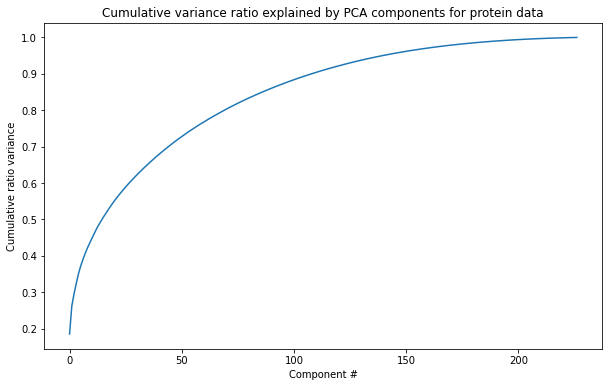

In [19]:
plt.subplots(figsize=(10, 6))
plt.plot(Sample_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for protein data');

The first fifty  explain around 70% of the variance of the data. We will use the first 2 principal components for datavisualisation even though they explain only around 26% of the variance in the data

In [20]:
Sample_pca_x = Sample_pca.transform(Training_protein_peptide_select_pca_scale)

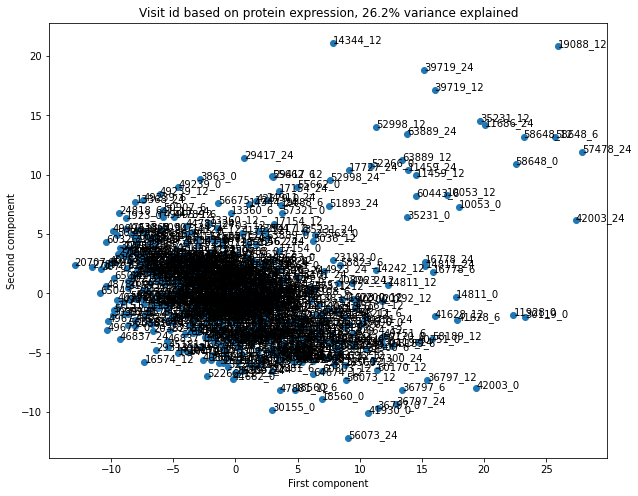

In [21]:
x = Sample_pca_x[:, 0]
y = Sample_pca_x[:, 1]
Visit_id = pca_protein.index
pc_var = 100 * Sample_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Visit id based on protein expression, {pc_var:.1f}% variance explained')
for s, x, y in zip(Visit_id, x, y):
    plt.annotate(s, (x, y))

What does the PCA analyses looks like if we consider the peptide abundance values rather than the NPX values

In [22]:
Training_protein_peptide_select_peptide=Training_protein_peptide_select.loc[:,["visit_id","Peptide","Normalised_PeptideAbundance"]]
pca_peptide=Training_protein_peptide_select_peptide.pivot(index="visit_id",columns="Peptide",values="Normalised_PeptideAbundance")
pca_peptide.head()
pca_peptide=pca_peptide.fillna(0)
columns_1=pca_peptide.columns


In [23]:
Training_protein_peptide_select_peptide_pca_scale = scale(pca_peptide)
#As np array convert into dataframe
Training_protein_peptide_select_peptide_pca_scale_df = pd.DataFrame(Training_protein_peptide_select_peptide_pca_scale,columns=columns_1)
Training_protein_peptide_select_peptide_pca_scale_df.index=pca_peptide.index
Training_protein_peptide_select_peptide_pca_scale_df.head()
Training_protein_peptide_select_peptide_pca_scale_df.shape

(671, 968)

In [24]:
Sample_pca_peptide = PCA().fit(Training_protein_peptide_select_peptide_pca_scale)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


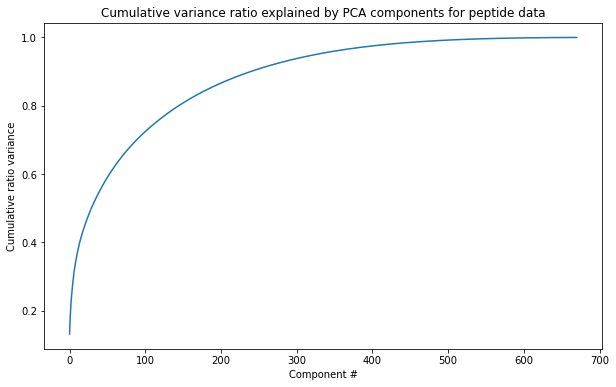

In [163]:
plt.subplots(figsize=(10, 6))
plt.plot(Sample_pca_peptide.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for peptide data');

The first 100 principal components in the peptide data explain around 70% of the variance of the data

In [25]:
Sample_pca_peptide_x = Sample_pca_peptide.transform(Training_protein_peptide_select_peptide_pca_scale)

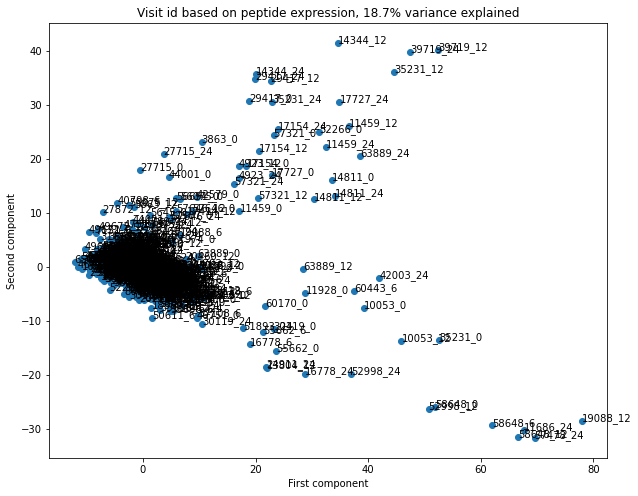

In [26]:
x = Sample_pca_peptide_x[:, 0]
y = Sample_pca_peptide_x[:, 1]
Visit_id = pca_peptide.index
pc_var = 100 * Sample_pca_peptide.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Visit id based on peptide expression, {pc_var:.1f}% variance explained')
for s, x, y in zip(Visit_id, x, y):
    plt.annotate(s, (x, y))

Again no definite pattern can be seen and the first two principal components explain only a small amount of variance

We can see that we have 271 proteins and 937 peptides, but all of them will not be important for predicting updrs scores. We have to do feature engineering to select those features. 
Given that there are so many peptides we will remove those which have variance less than 1 

In [52]:
variance_peptide=pca_peptide.var(axis=0)
drop=variance_peptide[variance_peptide<1].index
pca_peptide_select=pca_peptide.drop(drop, axis=1)
pca_peptide_select.shape

(671, 902)

In [45]:
We can combine the protein and peptide data in a wide format along with the UPDRS scores, which would make it easier to do next steps

139

In [55]:
protein_peptide_training=pca_peptide_select.merge(pca_protein,on=['visit_id'])
Training_protein_peptide_clinical= protein_peptide_training.merge(Training_clinical,  on=['visit_id'])
Training_protein_peptide_clinical.head()

,visit_id,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,...,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,patient_id,visit_month,updrs_1,updrs_2,updrs_3
0,10053_0,22.649812,14.929462,22.882983,0.000000,0.000000,0.000000,15.508671,17.849307,0.000000,...,17.441380,16.007991,13.908955,0.000000,14.215032,10053,0,3.0,0.0,13.0
1,10053_12,22.594574,15.673905,22.363028,0.000000,0.000000,0.000000,15.812641,16.724647,15.485748,...,17.389808,16.002905,0.000000,13.182340,14.649357,10053,12,4.0,2.0,8.0
2,10138_12,22.820025,15.492704,23.339044,0.000000,14.351919,16.024583,15.753789,16.280037,22.564118,...,17.806449,16.701361,14.670529,14.388138,12.899814,10138,12,3.0,6.0,31.0
3,10138_24,23.716941,15.796402,22.719452,13.750864,13.425767,15.958387,15.168194,15.060058,21.013883,...,17.431122,15.859908,13.625618,13.881439,12.590716,10138,24,4.0,7.0,19.0
4,10174_0,22.603838,15.928708,22.991626,14.559712,13.789870,16.938385,15.294901,18.401100,22.140654,...,17.118971,16.137492,14.586676,13.617881,13.722914,10174,0,3.0,0.0,2.0
